#Importing Data

In [ ]:
!pip install transformers
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"



In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score,confusion_matrix,ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler    
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import torch
import numpy as np
import pandas as pd
from transformers import BertTokenizer
from torch import nn
from transformers import BertModel
import nltk
from torch.optim.lr_scheduler import ReduceLROnPlateau
import string
import matplotlib.pyplot as plt
%matplotlib inline
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer
from torch.optim import Adam
from tqdm import tqdm

#Download nltk

In [ ]:
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

#Splitting , Balancing and  Preprocessing

In [ ]:
data = pd.read_csv('../input/imdb-dataset-of-50k-movie-reviews/IMDB Dataset.csv')


training_data_review=data

training_data_review['tokenized'] = training_data_review['review'].apply(word_tokenize)

training_data_review['review_lowercase']=training_data_review['tokenized'].apply(lambda x : [word.lower() for word in x])
punc = string.punctuation
training_data_review['no_punc']=training_data_review['review_lowercase'].apply(lambda x: [word for word in x if word not in punc])
stop_words = set(stopwords.words('english'))
training_data_review['stopwords_removed'] = training_data_review['no_punc'].apply(lambda x: [word for word in x if word not in stop_words])
training_data_review.head()
training_data_review['pos_tags'] = training_data_review['stopwords_removed'].apply(nltk.tag.pos_tag)

def get_wordnet_pos(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN


training_data_review['wordnet_pos'] = training_data_review['pos_tags'].apply(lambda x: [(word, get_wordnet_pos(pos_tag)) for (word, pos_tag) in x])
wnl = WordNetLemmatizer()
training_data_review['lemmatized'] = training_data_review['wordnet_pos'].apply(lambda x: [wnl.lemmatize(word, tag) for word, tag in x])


In [ ]:
training_data_review['lemmatized']=training_data_review['lemmatized'].apply(lambda x:(" ".join(x)))


x_train, x_test,y_train,y_test = train_test_split(np.array(training_data_review['lemmatized']),np.array(training_data_review['sentiment']), test_size=0.2, random_state=70)
x_train2,x_valid,y_train2,y_valid = train_test_split(x_train,y_train,test_size=0.125,random_state=70)
#####IFCORRECT balance data
training_data_review2=pd.DataFrame(x_train2.reshape(-1,1),columns=['review'])
training_data_review2['sentiment']=pd.DataFrame(y_train2.reshape(-1,1))

validation_data_review=pd.DataFrame(x_valid.reshape(-1,1),columns=["review"])
validation_data_review['sentiment']=pd.DataFrame(y_valid.reshape(-1,1))

testing_data_review1=pd.DataFrame(x_test.reshape(-1,1),columns=["review"])
testing_data_review1['sentiment']=pd.DataFrame(y_test.reshape(-1,1))


In [ ]:
import gc
del data
del training_data_review
gc.collect()

100

# Create Dataset Class

In [ ]:
labels={'negative':0,'positive':1}
class Dataset(torch.utils.data.Dataset):

    def __init__(self, df):
        tokenizer = BertTokenizer.from_pretrained('bert-base-cased')
        self.labels = [labels[label] for label in df['sentiment']] #Extract the labels from the dataframe
        self.texts = [tokenizer(text, 
                               padding='max_length', max_length = 512, truncation=True,
                                return_tensors="pt") for text in df['review']]#Tokenize the reviews 

    def classes(self):
        return self.labels #Return the labels
 
    def __len__(self):
        return len(self.labels)#Return the number of labels

    def get_batch_labels(self, idx):
        # Fetch a batch of labels
        return np.array(self.labels[idx])

    def get_batch_texts(self, idx):
        # Fetch a batch of inputs
        return self.texts[idx]

    def __getitem__(self, idx):

        batch_texts = self.get_batch_texts(idx)#Return a batch of labels
        batch_y = self.get_batch_labels(idx)#Return a batch of reviews

        return batch_texts, batch_y

#Create the Neural Network

In [ ]:
class BertClassifier(nn.Module):

    def __init__(self, dropout=0.1):

        super(BertClassifier, self).__init__()

        self.bert = BertModel.from_pretrained('bert-base-cased')
        self.dropout = nn.Dropout(p=dropout,inplace=False) #Required for regularization to reduce overfitting and is used to avoid overfitting by zeroing some elements from input tensors
        self.linear_in = nn.Linear(768, 512)
        self.relu=nn.ReLU()
        self.linear_1 =nn.Linear(512, 256)
        self.relu_1 = nn.ReLU()
        self.linear_2 =nn.Linear(256, 128)
        self.relu_2 = nn.ReLU()
        self.linear_3 =nn.Linear(128, 64)
        self.relu_3 = nn.ReLU()
        self.linear_4 =nn.Linear(64,1)
        

    def forward(self, input_id, mask): 

        _, pooled_output = self.bert(input_ids= input_id, attention_mask=mask,return_dict=False) #pooled_output contains the CLS embedding
        dropout_output = self.dropout(pooled_output)#Dropout to avoid overfitting
        dropout_output =self.relu (self.linear_in(dropout_output))
        dropout_output =self.relu_1 (self.linear_1(dropout_output))
        dropout_output =self.relu_2 (self.linear_2(dropout_output))
        dropout_output =self.relu_3 (self.linear_3(dropout_output))
        dropout_output = (self.linear_4(dropout_output))

        return dropout_output

In [ ]:
def calculate_accuracy(y_test,y_predicted):
  predicted_label=torch.round(torch.sigmoid(y_predicted))

  no_correct_samples=(predicted_label==y_test).sum().float()

  return no_correct_samples

#Train The Model

In [ ]:


def train(model, train_data, val_data, learning_rate, epochs,processed):

    train, val = Dataset(train_data), Dataset(val_data) #Extracts the text and label from the given data

    train_dataloader = torch.utils.data.DataLoader(train, batch_size=1, shuffle=True)#While training a model,pass samples in “minibatches”, reshuffle the data at every epoch to reduce model overfitting
    val_dataloader = torch.utils.data.DataLoader(val, batch_size=1)

    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")

    criterion = nn.BCEWithLogitsLoss()
    optimizer = Adam(model.parameters(), lr= learning_rate)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience = 1)
    
    if use_cuda:
      model = model.cuda()
      criterion = criterion.cuda()

    min_loss=100000000000
    current_loss=0
    for epoch_num in range(epochs):

            total_acc_train = 0
            total_loss_train = 0

            for train_input, train_label in tqdm(train_dataloader):

                train_label = train_label.to(torch.float32)
                train_label=train_label.to(device)
                mask = train_input['attention_mask'].to(device)
                input_id = train_input['input_ids'].squeeze(1).to(device)

                output = model(input_id, mask)
                
                
                batch_loss = criterion(output, train_label.unsqueeze(1))
                total_loss_train += batch_loss.item()#Extract the loss as a float and add it to the total loss
                
               
                acc = calculate_accuracy(train_label,output)
               
                total_acc_train += acc

                model.zero_grad()#zero out the accumulted gradients
                batch_loss.backward()#Update weights and Biases
                optimizer.step()#Perform a single optimization step
            
            total_acc_val = 0
            total_loss_val = 0

            with torch.no_grad():# Disable gradient calculation.
            #Model is being validated so there is no need to calculate gradients. It will reduce memory consumption for computations that would otherwise have requires_grad=True.

                for val_input, val_label in val_dataloader:
                    val_label=val_label.to(torch.float32)
                    val_label = val_label.to(device)
                    mask = val_input['attention_mask'].to(device)
                    input_id = val_input['input_ids'].squeeze(1).to(device)

                    output = model(input_id, mask)
                    
                    
                    batch_loss = criterion(output, val_label.unsqueeze(1))
                    total_loss_val += batch_loss.item()
                    
                    
                    acc = calculate_accuracy(val_label,output)
                    
                    total_acc_val += acc

            current_loss=total_loss_val#Calculate the total validation loss.
            scheduler.step(current_loss)
            if(current_loss<min_loss): 
                min_loss=current_loss
                if(processed==1):
                  PATH='model.pt'
                elif(processed==0):
                  PATH='model_up.pt'
                torch.save({
                  'epoch': epoch_num,
                  'model_state_dict': model.state_dict(),
                  'optimizer_state_dict': optimizer.state_dict(),
                  'loss': min_loss,
                  }, PATH)
                

            print(
                f'Epochs: {epoch_num + 1} | Train Loss: {total_loss_train / len(train_data): .3f} \
                | Train Accuracy: {total_acc_train / len(train_data): .3f} \
                | Val Loss: {total_loss_val / len(val_data): .3f} \
                | Val Accuracy: {total_acc_val / len(val_data): .3f}')
            
            for param_group in optimizer.param_groups:
              print(param_group['lr'])
            gc.collect()
            
                  
EPOCHS = 5
model = BertClassifier()
LR = 1e-5
processed=1


train(model, training_data_review2.iloc[0:5000,:], validation_data_review.iloc[0:2000,:], LR, EPOCHS,processed)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 500/500 [01:27<00:00,  5.70it/s]


Epochs: 1 | Train Loss:  0.694                 | Train Accuracy:  0.478                 | Val Loss:  0.694                 | Val Accuracy:  0.455
1e-05


100%|██████████| 500/500 [01:28<00:00,  5.62it/s]


Epochs: 2 | Train Loss:  0.693                 | Train Accuracy:  0.516                 | Val Loss:  0.694                 | Val Accuracy:  0.455
1e-05


100%|██████████| 500/500 [01:36<00:00,  5.17it/s]


Epochs: 3 | Train Loss:  0.693                 | Train Accuracy:  0.516                 | Val Loss:  0.695                 | Val Accuracy:  0.455
1.0000000000000002e-06


100%|██████████| 500/500 [01:30<00:00,  5.55it/s]


Epochs: 4 | Train Loss:  0.692                 | Train Accuracy:  0.516                 | Val Loss:  0.692                 | Val Accuracy:  0.455
1.0000000000000002e-06


100%|██████████| 500/500 [01:30<00:00,  5.54it/s]


Epochs: 5 | Train Loss:  0.683                 | Train Accuracy:  0.650                 | Val Loss:  0.680                 | Val Accuracy:  0.710
1.0000000000000002e-06


#Evaluate The Model On Test Data

/usr/local/lib/python3.7/dist-packages/pandas/core/generic.py:6619: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return self._update_inplace(result)


              precision    recall  f1-score   support

    negative       0.47      1.00      0.64        95
    positive       0.00      0.00      0.00       105

    accuracy                           0.48       200
   macro avg       0.24      0.50      0.32       200
weighted avg       0.23      0.47      0.31       200



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


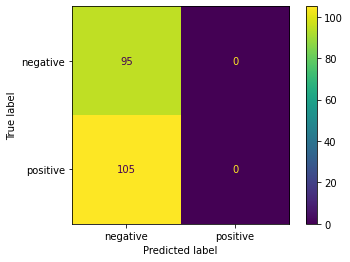

In [ ]:
def evaluate(model, test_data):

    test = Dataset(test_data)

    test_dataloader = torch.utils.data.DataLoader(test, batch_size=1)

    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")

    if use_cuda:
      model = model.cuda()

    total_acc_test = 0
    y_pred = []
    y_pred=torch.tensor(y_pred)
    y_pred=y_pred.to(device)
    with torch.no_grad():

        for test_input, test_label in test_dataloader:

              test_label = test_label.to(device)
              mask = test_input['attention_mask'].to(device)
              input_id = test_input['input_ids'].squeeze(1).to(device)

              output = model(input_id, mask)
              y_pred=torch.cat((y_pred,output))
              output=(output>0.5).float()
              acc = (output == test_label).sum()
              
              total_acc_test += acc
        
      
        
        test_data['sentiment'].replace({'positive':1,'negative':0},inplace=True)
        y_test=test_data['sentiment'].to_numpy()
        y_pred=torch.flatten(y_pred)
        y_pred=y_pred.detach().cpu().numpy()
        y_pred=np.where(y_pred > 0.5, 1, 0)
        classes=['negative','positive']
        
        
        net_classification_report=classification_report(y_test,y_pred,target_names=classes)    
        print(net_classification_report)
        conf_mat=confusion_matrix(y_test,y_pred)

        
        disp=ConfusionMatrixDisplay(confusion_matrix=conf_mat,display_labels=classes)
        disp.plot()
        plt.show()

        gc.collect()
    

#Load Best Model
PATH='model.pt'
checkpoint = torch.load(PATH)
model.load_state_dict(checkpoint['model_state_dict'])
#optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
epoch = checkpoint['epoch']
loss = checkpoint['loss']
#print the best model parameters





evaluate(model, testing_data_review1.iloc[0:2000,:])

# Unpreprocessed Data

In [ ]:
gc.collect()
data = pd.read_csv('../input/imdb-dataset-of-50k-movie-reviews/IMDB Dataset.csv')
x_train_up, x_test_up,y_train_up,y_test_up = train_test_split(np.array(data.iloc[:,:-1]),np.array(data['sentiment']), test_size=0.2, random_state=70)
x_train2_up,x_valid_up,y_train2_up,y_valid_up = train_test_split(x_train_up,y_train_up,test_size=0.125,random_state=70)

x_train2_up=pd.DataFrame(x_train2_up.reshape(-1,1),columns=['review'])
x_train2_up['sentiment']=pd.DataFrame(y_train2_up.reshape(-1,1))

x_valid_up=pd.DataFrame(x_valid_up.reshape(-1,1),columns=['review'])
x_valid_up['sentiment']=pd.DataFrame(y_valid_up.reshape(-1,1))

x_test_up=pd.DataFrame(x_test_up.reshape(-1,1),columns=['review'])
x_test_up['sentiment']=pd.DataFrame(y_test_up.reshape(-1,1))


In [ ]:

EPOCHS = 5
model_up = BertClassifier()
LR = 1e-5
processed=0

train(model_up, x_train2_up.iloc[:5000,:], x_valid_up.iloc[:2000,:], LR, EPOCHS,processed)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 500/500 [01:33<00:00,  5.34it/s]


Epochs: 1 | Train Loss:  0.684                 | Train Accuracy:  0.572                 | Val Loss:  0.646                 | Val Accuracy:  0.730
1e-05


100%|██████████| 500/500 [01:31<00:00,  5.44it/s]


Epochs: 2 | Train Loss:  0.561                 | Train Accuracy:  0.786                 | Val Loss:  0.493                 | Val Accuracy:  0.810
1e-05


100%|██████████| 500/500 [01:31<00:00,  5.46it/s]


Epochs: 3 | Train Loss:  0.397                 | Train Accuracy:  0.840                 | Val Loss:  0.521                 | Val Accuracy:  0.790
1e-05


100%|██████████| 500/500 [01:32<00:00,  5.39it/s]


Epochs: 4 | Train Loss:  0.258                 | Train Accuracy:  0.924                 | Val Loss:  0.597                 | Val Accuracy:  0.770
1.0000000000000002e-06


100%|██████████| 500/500 [01:31<00:00,  5.44it/s]


Epochs: 5 | Train Loss:  0.201                 | Train Accuracy:  0.946                 | Val Loss:  0.567                 | Val Accuracy:  0.795
1.0000000000000002e-06


/usr/local/lib/python3.7/dist-packages/pandas/core/generic.py:6619: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return self._update_inplace(result)


              precision    recall  f1-score   support

    negative       0.83      0.83      0.83        95
    positive       0.85      0.85      0.85       105

    accuracy                           0.84       200
   macro avg       0.84      0.84      0.84       200
weighted avg       0.84      0.84      0.84       200



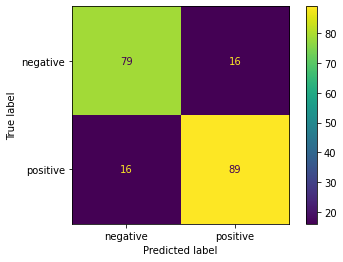

In [ ]:
#Load Best Model
PATH='model_up.pt'
checkpoint = torch.load(PATH)
model_up.load_state_dict(checkpoint['model_state_dict'])
#optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
epoch = checkpoint['epoch']
loss = checkpoint['loss']
#print the best model parameters

evaluate(model_up, x_test_up.iloc[:2000,:])